## Preprocess Data

## Combine Crime Data with Census Datax

In [3]:
import pandas as pd
from fuzzywuzzy import process


# Load Crime Data
crime_df = pd.read_csv("Final_Crime_Statistics.csv", encoding='latin1')
crime_df.columns = crime_df.columns.str.lower()


# Load Census Data
census_2016 = pd.read_csv("Census_Data_2016.csv")
census_2021 = pd.read_csv("Census_Data.csv", encoding="ISO-8859-1")

# Merging with 2016 Census
crime_11_18 = crime_df[crime_df['year'].between(2011, 2018)].copy()

ids_2016 = [1, 4, 6, 9, 13, 24, 39, 40, 742, 751, 847, 1324, 1337, 1684, 1685, 1686]
census_filtered_2016 = census_2016[
    census_2016['Member ID: Profile of Census Subdivisions (2247)'].isin(ids_2016)
]

pivoted_2016 = census_filtered_2016.pivot_table(
    index='GEO_NAME',
    columns='Member ID: Profile of Census Subdivisions (2247)',
    values='Dim: Sex (3): Member ID: [1]: Total - Sex',
    aggfunc='first'
).reset_index()

id_map_2016 = {
    1: 'total_population', 4: 'total_private_dwellings', 6: 'population_density',
    9: 'pct_0_14', 13: 'pct_15_64', 24: 'pct_65_plus', 39: 'avg_age',
    40: 'median_age', 742: 'median_income', 751: 'avg_income',
    847: 'low_income_households', 1324: 'total_visible_minority',
    1337: 'not_visible_minority', 1684: 'no_diploma', 1685: 'highschool', 1686: 'post_secondary'
}
pivoted_2016.rename(columns=id_map_2016, inplace=True)

geo_names_2016 = pivoted_2016['GEO_NAME'].tolist()
cities_11_18 = crime_11_18['city'].dropna().unique()
city_to_geo_2016 = {city: process.extractOne(city, geo_names_2016)[0] for city in cities_11_18}
crime_11_18['matched_geo_name'] = crime_11_18['city'].map(city_to_geo_2016)

merged_11_18 = crime_11_18.merge(
    pivoted_2016, how='left', left_on='matched_geo_name', right_on='GEO_NAME'
).drop(columns=['GEO_NAME'])

# Merging with 2021 Census 
crime_19_23 = crime_df[crime_df['year'].between(2019, 2023)].copy()

ids_2021 = [2, 4, 6, 9, 13, 24, 39, 40, 318, 321, 335, 1684, 1697, 1999, 2000, 2001]
census_filtered_2021 = census_2021[census_2021['CHARACTERISTIC_ID'].isin(ids_2021)]

pivoted_2021 = census_filtered_2021.pivot_table(
    index='GEO_NAME',
    columns='CHARACTERISTIC_ID',
    values='C1_COUNT_TOTAL',
    aggfunc='first'
).reset_index()

id_map_2021 = {
    2: 'total_population', 4: 'total_private_dwellings', 6: 'population_density',
    9: 'pct_0_14', 13: 'pct_15_64', 24: 'pct_65_plus', 39: 'avg_age',
    40: 'median_age', 318: 'median_income', 321: 'avg_income',
    335: 'low_income_households', 1684: 'total_visible_minority',
    1697: 'not_visible_minority', 1999: 'no_diploma', 2000: 'highschool', 2001: 'post_secondary'
}
pivoted_2021.rename(columns=id_map_2021, inplace=True)

geo_names_2021 = pivoted_2021['GEO_NAME'].tolist()
cities_19_23 = crime_19_23['city'].dropna().unique()
city_to_geo_2021 = {city: process.extractOne(city, geo_names_2021)[0] for city in cities_19_23}
crime_19_23['matched_geo_name'] = crime_19_23['city'].map(city_to_geo_2021)

merged_19_23 = crime_19_23.merge(
    pivoted_2021, how='left',
    left_on='matched_geo_name',
    right_on='GEO_NAME'
).drop(columns=['GEO_NAME'])

# Final Dataset
final_df = pd.concat([merged_11_18, merged_19_23], ignore_index=True)
final_df.to_csv("Crime_Data_With_Census_2013-2023.csv", index=False)

print("✅ Final file generated: Crime_Data_Census_2011_2023.csv with 2016 + 2021 census.")

crime_data = pd.read_csv('Crime_Data_With_Census_2013-2023.csv')

# Get Only Data from 2013
crime_data = crime_data[crime_data['year'] >=2013]
crime_data.to_csv("Crime_Data_With_Census_2013_2023.csv")


crime_data = pd.read_csv('Crime_Data_With_Census_2013_2023.csv')

crime_data = crime_data.drop(columns = ['matched_geo_name'])

crime_data.drop(columns=crime_data.columns[0], axis=1, inplace=True)
crime_data = crime_data.dropna()
crime_data.to_csv('Crime_Data_Census_2013_2023.csv')

/opt/anaconda3/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


✅ Final file generated: Crime_Data_Census_2011_2023.csv with 2016 + 2021 census.


In [4]:
import folium
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('Crime_Data_Census_2013_2023.csv')

# Convert string-based numerics to float
numeric_cols = [
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age', 'avg_income', 'median_income',
    'low_income_households', 'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Features to include
features = [
    'incidents', 'rates', 'latitude', 'longitude',
    'total_population', 'total_private_dwellings', 'population_density',
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age',
    'avg_income', 'median_income', 'low_income_households',
    'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

# Filter for year 2021 and drop rows with missing data
df_filtered = df[df['year'].isin([2021])].dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])

## KMEANS

In [6]:
from sklearn.cluster import KMeans

map_center = [df_filtered['latitude'].mean(), df_filtered['longitude'].mean()]
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
] 

# Initialize KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df_filtered['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate using Silhouette
sil_score_kmeans = silhouette_score(X_scaled, df_filtered['KMeans_Cluster'])
print(f"Silhouette Score (KMeans): {sil_score_kmeans:.2f}")

# Cluster counts
print("KMeans Cluster Counts:")
print(df_filtered['KMeans_Cluster'].value_counts())

# Map
kmeans_map = folium.Map(location=map_center, zoom_start=8)
for _, row in df_filtered.iterrows():
    color = cluster_colors[row['KMeans_Cluster'] % len(cluster_colors)]
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>KMeans Cluster: {row['KMeans_Cluster']}"
    ).add_to(kmeans_map)

kmeans_map.save("2021_FINAL_KMEANS_Cluster_MAP.html")
print("KMeans crime map saved as '2021_FINAL_KMEANS_Cluster_MAP.html'.")

# Cluster Feature Profiles
kmeans_profiles = df_filtered.groupby("KMeans_Cluster")[features].mean().round(2)
print("KMeans Cluster Profiles:")
print(kmeans_profiles)

kmeans_profiles.to_csv("2021_FINAL_KMEANS_Cluster_Profiles.csv")

# References
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

Silhouette Score (KMeans): 0.41
KMeans Cluster Counts:
KMeans_Cluster
2    34
6    16
4    12
3    12
1     8
0     6
5     4
Name: count, dtype: int64
KMeans crime map saved as '2021_FINAL_KMEANS_Cluster_MAP.html'.
KMeans Cluster Profiles:
                incidents     rates  latitude  longitude  total_population  \
KMeans_Cluster                                                               
0                 1772.00   4330.03     44.96     -64.15           5866.00   
1                  533.00   2451.77     44.93     -63.83          20734.50   
2                  390.12   2247.52     45.57     -61.96           5866.00   
3                  179.67   4859.95     43.70     -65.18           5074.00   
4                  285.17  12041.87     45.57     -62.26           2565.67   
5                  655.50   3075.73     44.83     -65.56            491.00   
6                  280.00   3745.99     44.67     -64.72           7317.25   

                total_private_dwellings  population_dens

## DBSCAN

In [8]:
import folium
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('Crime_Data_Census_2013_2023.csv')

# Convert string-based numerics to float
numeric_cols = [
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age', 'avg_income', 'median_income',
    'low_income_households', 'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Features to include
features = [
    'incidents', 'rates', 'latitude', 'longitude',
    'total_population', 'total_private_dwellings', 'population_density',
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age',
    'avg_income', 'median_income', 'low_income_households',
    'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

# Filter year 2021 and drop rows with missing data
df_filtered = df[df['year'].isin([2021])].dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])


In [9]:
from sklearn.cluster import DBSCAN

map_center = [df_filtered['latitude'].mean(), df_filtered['longitude'].mean()]
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]

# Initialize DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=3)
df_filtered['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

# Evaluate silhouette score for valid clusters
valid_dbscan = df_filtered[df_filtered['DBSCAN_Cluster'] != -1]
if valid_dbscan['DBSCAN_Cluster'].nunique() > 1:
    sil_score_db = silhouette_score(
        scaler.transform(valid_dbscan[features]), valid_dbscan['DBSCAN_Cluster']
    )
    print(f"Silhouette Score (DBSCAN): {sil_score_db:.2f}")
else:
    print("Not enough clusters for DBSCAN silhouette score.")

# Cluster counts
print("DBSCAN Cluster Counts:")
print(df_filtered['DBSCAN_Cluster'].value_counts())

# Map
dbscan_map = folium.Map(location=map_center, zoom_start=8)
for _, row in df_filtered.iterrows():
    cid = row['DBSCAN_Cluster']
    color = 'gray' if cid == -1 else cluster_colors[cid % len(cluster_colors)]
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>DBSCAN Cluster: {cid}"
    ).add_to(dbscan_map)

dbscan_map.save("2021_FINAL_DBSCAN_Cluster_MAP.html")
print("DBSCAN crime map saved as '2021_FINAL_DBSCAN_Cluster_MAP.html'.")

# Print and save Cluster Feature Profiles
dbscan_profiles = df_filtered.groupby("DBSCAN_Cluster")[features].mean().round(2)
print("DBSCAN Cluster Profiles:")
print(dbscan_profiles)

dbscan_profiles.to_csv("2021_FINAL_DBSCAN_Cluster_Profiles.csv")

# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Silhouette Score (DBSCAN): 0.88
DBSCAN Cluster Counts:
DBSCAN_Cluster
-1    82
 1     4
 0     3
 2     3
Name: count, dtype: int64
DBSCAN crime map saved as '2021_FINAL_DBSCAN_Cluster_MAP.html'.
DBSCAN Cluster Profiles:
                incidents    rates  latitude  longitude  total_population  \
DBSCAN_Cluster                                                              
-1                 482.02  4553.52     45.08     -63.31           6815.66   
 0                 169.00  1571.22     44.24     -64.98           5866.00   
 1                  96.25  3361.08     43.76     -65.32           4288.00   
 2                 140.67  1841.43     46.49     -60.65           5866.00   

                total_private_dwellings  population_density  pct_0_14  \
DBSCAN_Cluster                                                          
-1                              3672.76               55.49    958.17   
 0                              3435.00                9.80    685.00   
 1                      

## HDBSCAN

In [11]:
import folium
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('Crime_Data_Census_2013_2023.csv')

# Convert string-based numerics to float
numeric_cols = [
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age', 'avg_income', 'median_income',
    'low_income_households', 'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Features to include
features = [
    'incidents', 'rates', 'latitude', 'longitude',
    'total_population', 'total_private_dwellings', 'population_density',
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age',
    'avg_income', 'median_income', 'low_income_households',
    'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

# Filter the year 2021 and drop rows with missing data
df_filtered = df[df['year'].isin([2021])].dropna(subset=features).copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[features])

In [12]:
# Initialise HDBSCAN clusterer
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
df_filtered['HDBSCAN_Cluster'] = clusterer.fit_predict(X_scaled)

valid_clusters = df_filtered[df_filtered['HDBSCAN_Cluster'] != -1].copy()
X_valid = scaler.transform(valid_clusters[features])  # re-transform only valid rows

if valid_clusters['HDBSCAN_Cluster'].nunique() > 1:
    sil_score = silhouette_score(X_valid, valid_clusters['HDBSCAN_Cluster'])
    print(f"Silhouette Score (HDBSCAN): {sil_score:.2f}")
else:
    print("Not enough clusters for silhouette score.")

# Cluster counts
print("HDBSCAN Cluster Counts:")
print(df_filtered['HDBSCAN_Cluster'].value_counts())

# Map
map_center = [df_filtered['latitude'].mean(), df_filtered['longitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=8)

# Define color palette
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]
print(f"Total points plotted: {len(df_filtered)}")

# Plot the markers
for _, row in df_filtered.iterrows():
    cluster_id = row["HDBSCAN_Cluster"]
    color = 'gray' if cluster_id == -1 else cluster_colors[cluster_id % len(cluster_colors)]

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>Cluster: {cluster_id}"
    ).add_to(crime_map)

# Find top 3 cities by number of incidents
top_cities = df_filtered.sort_values(by='incidents', ascending=False).head(3)

# Adding red location markers for top 3 cities
for _, row in top_cities.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=f"Top City: {row['city']}<br>incidents: {row['incidents']}<br>Cluster: {row['HDBSCAN_Cluster']}"
    ).add_to(crime_map)

# Save map
crime_map.save("2021_FINAL_HDBSCAN_Cluster_MAP.html")

# print and save Cluster Feature Profiles
cluster_profiles = df_filtered.groupby("HDBSCAN_Cluster")[features].mean().round(2)
print("Cluster Profiles:")
print(cluster_profiles)
cluster_profiles.to_csv("2021HDBSCAN_Cluster_Profiles.csv")

# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html

Silhouette Score (HDBSCAN): 0.49
HDBSCAN Cluster Counts:
HDBSCAN_Cluster
 8     43
 7      7
 5      7
 3      4
 6      4
 4      4
 9      4
 10     4
 0      4
 2      4
 1      4
-1      3
Name: count, dtype: int64
Total points plotted: 92
Cluster Profiles:
                 incidents     rates  latitude  longitude  total_population  \
HDBSCAN_Cluster                                                               
-1                 1203.67  18787.76     44.59     -64.46           3747.67   
 0                  603.00   3009.88     44.94     -64.13          19016.00   
 1                  463.00   1893.66     44.92     -63.54          22453.00   
 2                  313.00   6481.67     45.62     -61.99           8278.00   
 3                  484.50  13336.08     45.95     -60.60           3422.00   
 4                  655.50   3075.73     44.83     -65.56            491.00   
 5                  154.43   8033.72     45.42     -63.04           2287.29   
 6                  256.00 

In [13]:
import folium
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('Crime_Data_Census_2013_2023.csv')

# Convert string-based numerics to float
numeric_cols = [
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age', 'avg_income', 'median_income',
    'low_income_households', 'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Features to include
features = [
    'incidents', 'rates', 'latitude', 'longitude',
    'total_population', 'total_private_dwellings', 'population_density',
    'pct_0_14', 'pct_15_64', 'pct_65_plus',
    'avg_age', 'median_age',
    'avg_income', 'median_income', 'low_income_households',
    'total_visible_minority', 'not_visible_minority',
    'no_diploma', 'highschool', 'post_secondary'
]

# Filter year 2016 and drop rows with any missing data
df_filtered_16 = df[df['year'].isin([2016])].dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered_16[features])

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
df_filtered_16['HDBSCAN_Cluster'] = clusterer.fit_predict(X_scaled)


# Reset index 
valid_clusters = df_filtered_16[df_filtered_16['HDBSCAN_Cluster'] != -1].copy()
X_valid = scaler.transform(valid_clusters[features])  # re-transform only valid rows

if valid_clusters['HDBSCAN_Cluster'].nunique() > 1:
    sil_score = silhouette_score(X_valid, valid_clusters['HDBSCAN_Cluster'])
    print(f"Silhouette Score (HDBSCAN): {sil_score:.2f}")
else:
    print("Not enough clusters for silhouette score.")

# Cluster counts
print("HDBSCAN Cluster Counts:")
print(df_filtered_16['HDBSCAN_Cluster'].value_counts())

# Plot Map
map_center = [df_filtered_16['latitude'].mean(), df_filtered_16['longitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=8)

# Define color palette
cluster_colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'pink', 'yellow', 'cyan', 'brown', 'lightblue'
]
print(f"Total points plotted: {len(df_filtered_16)}")

# Plot markers on map
for _, row in df_filtered_16.iterrows():
    cluster_id = row["HDBSCAN_Cluster"]
    color = 'gray' if cluster_id == -1 else cluster_colors[cluster_id % len(cluster_colors)]

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"City: {row['city']}<br>Year: {row['year']}<br>Cluster: {cluster_id}"
    ).add_to(crime_map)

# Save map
crime_map.save("2016hdbscan_clustering_results.html")
print("HDBSCAN crime map saved as 'hdbscan_clustering_results.html'.")

# Print and save Cluster Feature Profiles
cluster_profiles = df_filtered_16.groupby("HDBSCAN_Cluster")[features].mean().round(2)
print("Cluster Profiles:")
print(cluster_profiles)
cluster_profiles.to_csv("2016HDBSCAN_Cluster_Profiles.csv")
df_filtered.to_csv("2016_HDBSCAN_Clustered_Data.csv", index=False)


Silhouette Score (HDBSCAN): 0.61
HDBSCAN Cluster Counts:
HDBSCAN_Cluster
-1     13
 8     12
 9     12
 0      8
 4      8
 13     7
 12     7
 10     5
 3      4
 6      4
 7      4
 14     4
 15     4
 1      4
 5      4
 11     4
 2      4
Name: count, dtype: int64
Total points plotted: 108
HDBSCAN crime map saved as 'hdbscan_clustering_results.html'.
Cluster Profiles:
                 incidents     rates  latitude  longitude  total_population  \
HDBSCAN_Cluster                                                               
-1                  764.77   4833.35     45.04     -64.23           6497.85   
 0                  243.50  10208.23     45.52     -62.04           2255.50   
 1                  688.00   1755.86     44.38     -64.31          24863.00   
 2                  408.50   1782.75     44.92     -63.54          22453.00   
 3                  210.50   1344.02     44.94     -64.13          15368.00   
 4                  265.00   3990.23     45.57     -61.99           4364

In [14]:
# Merge clusters from two years on city
comparison_df = df_filtered_16[['city', 'HDBSCAN_Cluster']].merge(
    df_filtered[['city', 'HDBSCAN_Cluster']],
    on='city',
    suffixes=('_2016', '_2021')
)

# Check where the cluster assignment changed
comparison_df['changed'] = comparison_df['HDBSCAN_Cluster_2016'] != comparison_df['HDBSCAN_Cluster_2021']
changes = comparison_df[comparison_df['changed'] == True]

print("Cities that changed cluster from 2016 to 2021:")
print(changes)

Cities that changed cluster from 2016 to 2021:
             city  HDBSCAN_Cluster_2016  HDBSCAN_Cluster_2021  changed
0        Eskasoni                     0                     3     True
1        Eskasoni                     0                     3     True
2        Eskasoni                     0                     3     True
3        Eskasoni                     0                     3     True
4        Eskasoni                     0                     3     True
..            ...                   ...                   ...      ...
395  Indian Brook                     0                     5     True
396  Indian Brook                     0                    -1     True
397  Indian Brook                     0                     5     True
398  Indian Brook                     0                     5     True
399  Indian Brook                     0                     5     True

[380 rows x 4 columns]


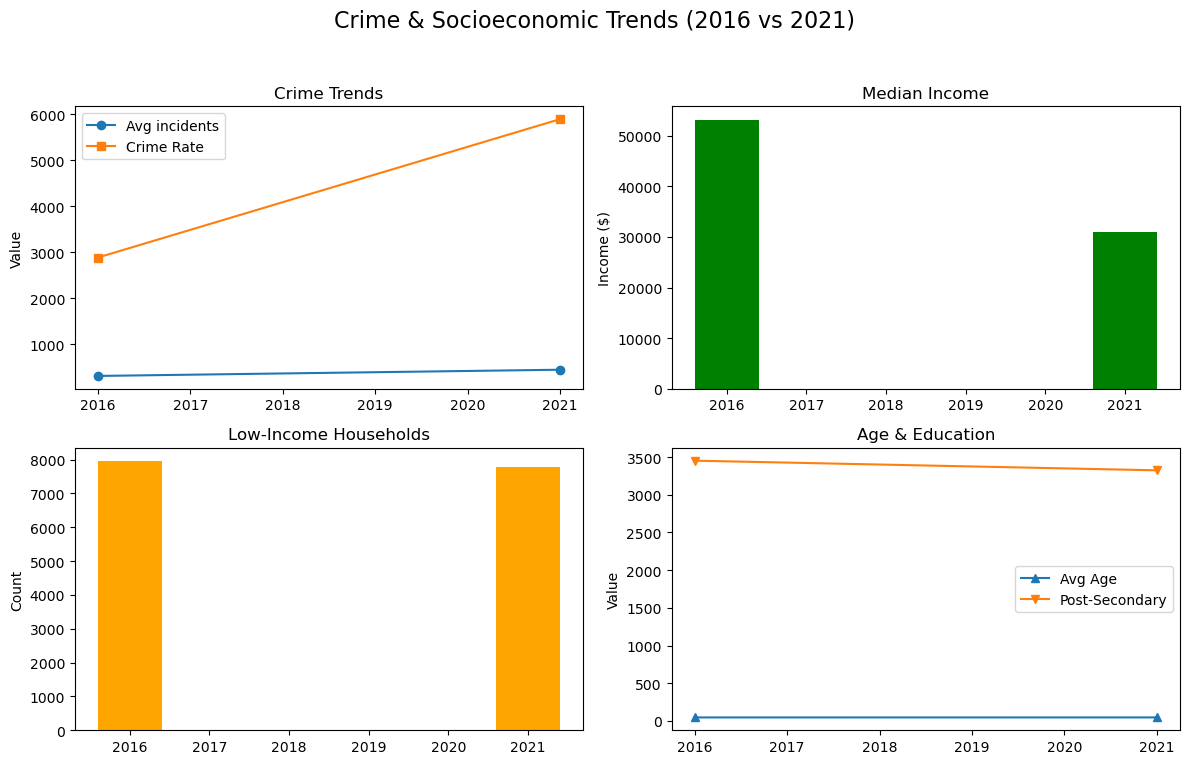

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
df_2016 = pd.read_csv("2016HDBSCAN_Cluster_Profiles.csv")
df_2021 = pd.read_csv("2021HDBSCAN_Cluster_Profiles.csv")

# Add year column
df_2016['year'] = 2016
df_2021['year'] = 2021

# Combine the datasets
combined_df = pd.concat([df_2016, df_2021], ignore_index=True)

# Group and calculate averages
trend_summary = combined_df.groupby('year')[
    ['incidents', 'rates', 'median_income', 'post_secondary', 'low_income_households', 'avg_age']
].mean().round(2).reset_index()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Crime & Socioeconomic Trends (2016 vs 2021)", fontsize=16)

# Plot 1: Crime incidents and rates
axes[0, 0].plot(trend_summary['year'], trend_summary['incidents'], marker='o', label='Avg incidents')
axes[0, 0].plot(trend_summary['year'], trend_summary['rates'], marker='s', label='Crime Rate')
axes[0, 0].set_title("Crime Trends")
axes[0, 0].set_ylabel("Value")
axes[0, 0].legend()

# Plot 2: Median Income
axes[0, 1].bar(trend_summary['year'], trend_summary['median_income'], color='green')
axes[0, 1].set_title("Median Income")
axes[0, 1].set_ylabel("Income ($)")

# Plot 3: Low-Income Households
axes[1, 0].bar(trend_summary['year'], trend_summary['low_income_households'], color='orange')
axes[1, 0].set_title("Low-Income Households")
axes[1, 0].set_ylabel("Count")

# Plot 4: Avg Age & Post-Secondary
axes[1, 1].plot(trend_summary['year'], trend_summary['avg_age'], marker='^', label='Avg Age')
axes[1, 1].plot(trend_summary['year'], trend_summary['post_secondary'], marker='v', label='Post-Secondary')
axes[1, 1].set_title("Age & Education")
axes[1, 1].set_ylabel("Value")
axes[1, 1].legend()


plt.savefig("trends.png",  format='png', dpi=300)

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
